In [1]:
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.metrics import accuracy_score
from pandas import Series

In [2]:
# load train dataset
train = pd.read_csv("./train.csv")
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [3]:
# get missing values in train dataset
train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

# Data analysis

In [4]:
# create functions to make charts for analysis
def make_crosstable_colname_and_survived(df: pd.DataFrame, col_name: str):
	feature_survived = pd.crosstab(df[col_name], df["Survived"])
	feature_survived.columns = feature_survived.columns.map({0: "Dead", 1: "Alive"})

	return feature_survived


def make_piechart(feature_survived: pd.DataFrame):
	feature_rows, feature_cols = feature_survived.shape
	n_cols = 3
	n_rows = (feature_rows / feature_cols + feature_rows % n_cols)
	plot_height = n_rows * 2.5
	plt.figure(figsize=(8, plot_height))

	for row in range(0, feature_rows):
		plt.subplot(n_rows, n_cols, row + 1)
		index_name = feature_survived.index[row]
		plt.pie(feature_survived.loc[index_name], labels=feature_survived.loc[index_name].index, autopct="%1.1f%%")
		plt.title(f"{index_name}' survived")

def show_piechart(df: pd.DataFrame, col_name: str):
	col_name_survived = make_crosstable_colname_and_survived(df, col_name)
	make_piechart(col_name_survived)

	return col_name_survived

C:\Users\wootj\AppData\Local\Temp/ipykernel_748/2288737278.py:17: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  plt.subplot(n_rows, n_cols, row + 1)


(Survived  Dead  Alive
 Sex                  
 female      81    233
 male       468    109,
 Survived  Dead  Alive
 Embarked             
 C           75     93
 Q           47     30
 S          427    217)

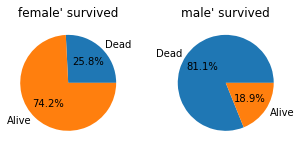

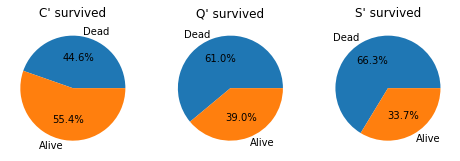

In [5]:
# check the relationship between features and survival rate
sex_piechart = show_piechart(df=train, col_name="Sex")
embarked_piechart = show_piechart(df=train, col_name="Embarked")
sex_piechart, embarked_piechart

# Preprocessing

In [6]:
# load test dataset
test = pd.read_csv("./test.csv")
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [7]:
def preprocess(df: pd.DataFrame):
	# sex
	df["Sex"] = df["Sex"].map({"female": 0, "male": 1})

	# embarked
	df["Embarked"].fillna("S", inplace=True)
	df["Embarked"] = df["Embarked"].map({"C": 0, "Q": 1, "S": 2})

	# title
	df["Title"] = df["Name"].str.extract(' ([A-Za-z]+)\.')
	df["Title"] = df["Title"].replace(["Capt", "Col", "Countess", "Don", "Dona", "Dr", "Jonkheer", "Lady", "Major", "Rev", "Sir"], "Other")
	df["Title"] = df["Title"].replace("Mlle", "Miss")
	df["Title"] = df["Title"].replace("Mme", "Mrs")
	df["Title"] = df["Title"].replace("Ms", "Miss")
	df["Title"] = df["Title"].map({"Master": 0, "Miss": 1, "Mr": 2, "Mrs": 3, "Other": 4})

	# age
	avg_age = df[["Title", "Age"]].groupby(["Title"]).mean()
	for i, row in avg_age.iterrows():
		null_ids = df[(df["Title"] == i) & (df["Age"].isnull())].index
		df.loc[null_ids, "Age"] = row[0]
	df["AgeCategory"] = pd.qcut(df["Age"], q=8, labels=range(1, 9))
	df["AgeCategory"] = df["AgeCategory"].astype(int)

	# cabin
	df["Cabin"].fillna("N", inplace=True)
	df["CabinCategory"] = df["Cabin"].str.slice(start=0, stop=1)
	df["CabinCategory"] = df["CabinCategory"].map({"N": 0, "C": 1, "B": 2, "D": 3, "E": 4, "A": 5, "F": 6, "G": 7, "T": 8})

	# fare
	df["Fare"].fillna(0, inplace=True)
	df["FareCategory"] = pd.qcut(df["Fare"], q=8, labels=range(1, 9))
	df["FareCategory"] = df["FareCategory"].astype(int)

	# sibsp, parch
	df["Family"] = df["SibSp"] + df["Parch"] + 1
	df.loc[df["Family"] > 4, "Family"] = 5
	df["IsAlone"] = 1
	df.loc[df["Family"] > 1, "IsAlone"] = 0

	# ticket
	df["TicketCategory"] = df["Ticket"].str.split()
	df["TicketCategory"] = [i[-1][0] for i in df["TicketCategory"]]
	df["TicketCategory"] = df["TicketCategory"].replace(["8", "9", "L"], "8")
	df["TicketCategory"] = pd.factorize(df["TicketCategory"])[0] + 1

	df.drop(["PassengerId", "Ticket", "Cabin", "Fare", "Name", "Age", "SibSp", "Parch"], axis=1, inplace=True)

	return df

In [8]:
# get preprocessing
train = preprocess(train)
test = preprocess(test)

train.info()
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 11 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Survived        891 non-null    int64
 1   Pclass          891 non-null    int64
 2   Sex             891 non-null    int64
 3   Embarked        891 non-null    int64
 4   Title           891 non-null    int64
 5   AgeCategory     891 non-null    int32
 6   CabinCategory   891 non-null    int64
 7   FareCategory    891 non-null    int32
 8   Family          891 non-null    int64
 9   IsAlone         891 non-null    int64
 10  TicketCategory  891 non-null    int64
dtypes: int32(2), int64(9)
memory usage: 69.7 KB
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 418 entries, 0 to 417
Data columns (total 10 columns):
 #   Column          Non-Null Count  Dtype
---  ------          --------------  -----
 0   Pclass          418 non-null    int64
 1   Sex             418 non-null    int64
 2   Embar

In [9]:
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", None)
train["Title"]

0      2
1      3
2      1
3      3
4      2
5      2
6      2
7      0
8      3
9      3
10     1
11     1
12     2
13     2
14     1
15     3
16     0
17     2
18     3
19     3
20     2
21     2
22     1
23     2
24     1
25     3
26     2
27     2
28     1
29     2
30     4
31     3
32     1
33     2
34     2
35     2
36     2
37     2
38     1
39     1
40     3
41     3
42     2
43     1
44     1
45     2
46     2
47     1
48     2
49     3
50     0
51     2
52     3
53     3
54     2
55     2
56     1
57     2
58     1
59     0
60     2
61     1
62     2
63     0
64     2
65     0
66     3
67     2
68     1
69     2
70     2
71     1
72     2
73     2
74     2
75     2
76     2
77     2
78     0
79     1
80     2
81     2
82     1
83     2
84     1
85     3
86     2
87     2
88     1
89     2
90     2
91     2
92     2
93     2
94     2
95     2
96     2
97     2
98     3
99     2
100    1
101    2
102    2
103    2
104    2
105    2
106    1
107    2
108    2
109    1
110    2
1

# Learning

In [10]:
# get input features and target
input = train.drop("Survived", axis=1).values
target = train["Survived"].values

x_train, x_valid, y_train, y_valid = train_test_split(input, target, test_size=0.4, stratify=target, random_state=0)

In [11]:
# experiment: 1
rf = RandomForestClassifier(n_estimators=50, criterion="entropy", max_depth=5, oob_score=True, random_state=10)
rf.fit(X=x_train, y=y_train)
pred = rf.predict(x_valid)
acc = accuracy_score(y_true=y_valid, y_pred=pred)
print(f"Accuracy is {acc:.3f} for {y_valid.shape[0]} people")

Accuracy is 0.829 for 357 people


In [20]:
# experiment: 2
rf_cls = RandomForestClassifier()
rf_paramgrid = {
    'max_depth' : [6, 8, 10, 15],
    'n_estimators': [50, 100, 300, 500, 700, 800, 900],
    'max_features': ['sqrt'],
    'min_samples_split': [2, 7, 15, 30],
    'min_samples_leaf': [1, 15, 30, 60],
    'bootstrap': [True, False],
    'criterion': ['gini', 'entropy']
    }

kfold = StratifiedKFold(n_splits=5)

rf_cls_grid = GridSearchCV(estimator=rf_cls, param_grid=rf_paramgrid, cv=kfold, scoring="accuracy", n_jobs=-1, verbose=1)
rf_cls_grid.fit(X=x_train, y=y_train)
rf_best = rf_cls_grid.best_estimator_

# get the best score
print(rf_cls_grid.best_score_)
# get the best params
print(rf_cls_grid.best_params_)
# get the best model
print(rf_cls_grid.best_estimator_)

Fitting 5 folds for each of 1792 candidates, totalling 8960 fits


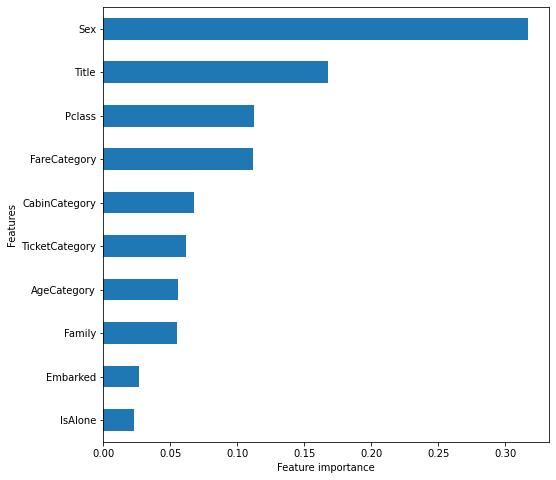

In [12]:
# check features that influences to model
feature_importance = rf.feature_importances_
fi = Series(data=feature_importance, index=train.drop(["Survived"], axis=1).columns)

plt.figure(figsize=(8, 8))
fi.sort_values(ascending=True).plot.barh()
plt.xlabel("Feature importance")
plt.ylabel("Features")
plt.show()

# Submission

In [15]:
# inference for test dataset
inference = rf.predict(test)
inference

C:\Users\wootj\Anaconda3\envs\PythonProject\lib\site-packages\sklearn\base.py:443: UserWarning: X has feature names, but RandomForestClassifier was fitted without feature names
  warnings.warn(


array([0, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 1, 1, 0, 0, 1, 1, 0, 1,
       1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1,
       1, 0, 0, 0, 1, 1, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 1,
       1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 1,
       1, 1, 1, 0, 1, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0,
       0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1,
       0, 0, 1, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1,
       1, 0, 1, 1, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 1,
       0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0,
       1, 0, 1, 0, 1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1,
       0, 0, 0, 0, 1, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 1, 1,
       0, 0, 0, 0, 1, 0, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 1, 1, 1, 1, 1, 0,
       0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 0, 0,

In [16]:
# make a submission file
submission = pd.read_csv("./gender_submission.csv")
submission["Survived"] = inference
submission.to_csv("./submission_20220130_squiduu.csv", index=False)